In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 17.2MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 14.7MB/s 
  Created wheel for wwf: filename=wwf-0.0.10-cp36-none-any.whl size=23155 sha256=f0ebce643cb1dda15db679ac84da81feefc673ed16a452e7a2ea48365c923e98
  Stored in directory: /root/.cache/pip/wheels/c7/22/a7/30cb5077503f2c5d1c0af9187090604237d9e075154d833eb5
Successfully built wwf


In [2]:
!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip

--2021-02-08 17:07:27--  https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cb3g53z4pbtaqvl/erm.zip [following]
--2021-02-08 17:07:27--  https://www.dropbox.com/s/dl/cb3g53z4pbtaqvl/erm.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucde4c813e408116d3564c49950f.dl.dropboxusercontent.com/cd/0/get/BIhKhIO6gTrQ-21JXFgdSn_dT5HOVAIR9c7UqGYz0u2SKb4O-Aeszdf8mkgBOCJRVqU1KZaT0kE3H450zHNEfbbR6fPrpLbOICKbnbYvw5GOnt2BxJVkh1vRWNHJvgX7YsU/file?dl=1# [following]
--2021-02-08 17:07:28--  https://ucde4c813e408116d3564c49950f.dl.dropboxusercontent.com/cd/0/get/BIhKhIO6gTrQ-21JXFgdSn_dT5HOVAIR9c7UqGYz0u2SKb4O-Aeszdf8mkgBOCJRVqU1KZaT0kE3H450zHNEfbbR6fPrpLbOICKbnbYvw5GOnt2BxJVkh1vRWNHJ

In [3]:
!unzip erm.zip

Archive:  erm.zip
replace dataset/test/no/anonymized_1421704.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/test/no/anonymized_1421704.jpg  
  inflating: dataset/test/no/anonymized_336537.jpg  
  inflating: dataset/test/no/anonymized_569526.jpg  
  inflating: dataset/test/no/anonymized_196860.jpg  
  inflating: dataset/test/no/anonymized_920184.jpg  
  inflating: dataset/test/no/anonymized_1348815.jpg  
  inflating: dataset/test/no/anonymized_225304.jpg  
  inflating: dataset/test/no/anonymized_816099.jpg  
  inflating: dataset/test/no/anonymized_260226.jpg  
  inflating: dataset/test/no/anonymized_1619231.jpg  
  inflating: dataset/test/no/anonymized_1314755.jpg  
  inflating: dataset/test/no/anonymized_1182585.jpg  
  inflating: dataset/test/no/anonymized_656024.jpg  
  inflating: dataset/test/no/anonymized_198917.jpg  
  inflating: dataset/test/no/anonymized_246204.jpg  
  inflating: dataset/test/no/anonymized_324557.jpg  
  inflating: dataset/test/no/anonymized_4

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='efficientnet_b2')
]

In [9]:
import timm
timm.list_models('*efficientnet_b2*')

['efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'tf_efficientnet_b2',
 'tf_efficientnet_b2_ap',
 'tf_efficientnet_b2_ns']

In [10]:
learn = timm_learner(dls512, 'efficientnet_b2',cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_ra-bcdf34b7.pth


SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=7.585775847473997e-07)

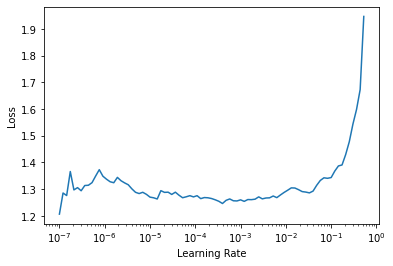

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.300370,0.892502,0.550459,0.571014,0.574344,00:26


Better model found at epoch 0 with valid_loss value: 0.8925022482872009.


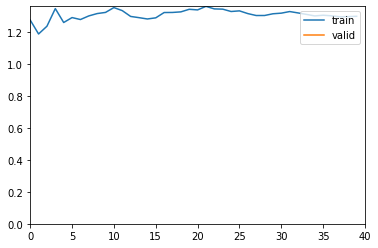

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.320004,0.917216,0.561162,0.580000,0.591837,00:31
1,1.298946,0.866563,0.571865,0.588235,0.612245,00:30
2,1.309422,0.897062,0.573394,0.587432,0.626822,00:30
3,1.285209,0.853952,0.579511,0.598837,0.600583,00:30
4,1.281173,0.867522,0.576453,0.594828,0.603499,00:30
5,1.241918,0.849149,0.588685,0.610119,0.597668,00:30
6,1.243357,0.856924,0.576453,0.596491,0.594752,00:30
7,1.238106,0.866605,0.585627,0.604046,0.609329,00:30
8,1.245236,0.865349,0.576453,0.599398,0.580175,00:31


Better model found at epoch 0 with valid_loss value: 0.917215883731842.


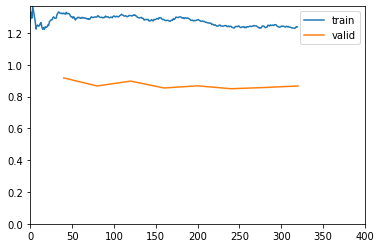

Better model found at epoch 1 with valid_loss value: 0.866563081741333.
Better model found at epoch 3 with valid_loss value: 0.8539524674415588.
Better model found at epoch 5 with valid_loss value: 0.8491485118865967.
No improvement since epoch 5: early stopping


In [12]:
learn.fine_tune(10,base_lr=1e-5)

In [13]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

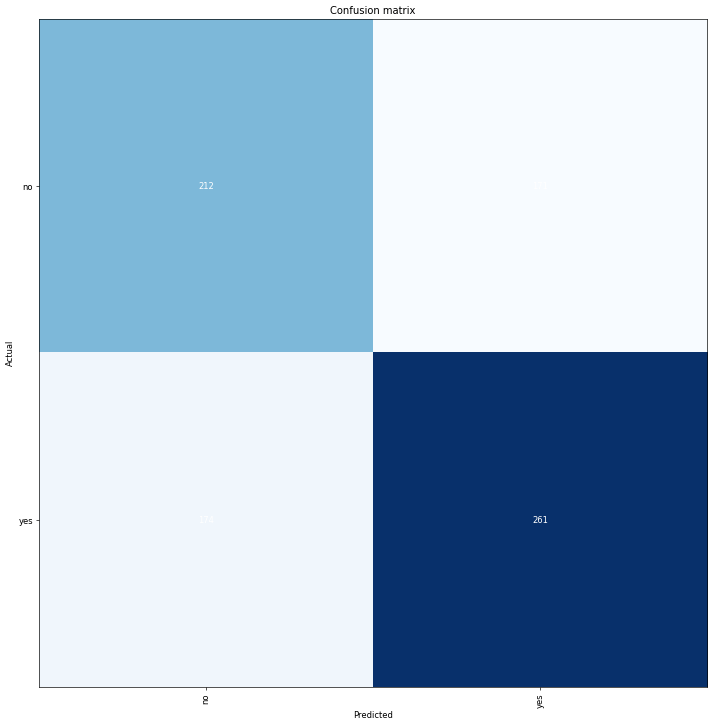

In [14]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [15]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5782396197319031.


(#4) [0.8217701315879822,0.5782396197319031,0.6041666666666666,0.6]

In [16]:
learn.export(fname='resnet50.pkl')